In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

start = time.time()

from qiskit import QuantumRegister, QuantumCircuit
from qiskit.aqua.components.uncertainty_models import UniformDistribution, UnivariateVariationalDistribution
from qiskit.aqua.components.variational_forms import RY

from qiskit.aqua.components.neural_networks.quantum_generator import QuantumGenerator
from qiskit.aqua.components.neural_networks import NumPyDiscriminator as NumpyDiscriminator

from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.components.initial_states import Custom

from qiskit import BasicAer

from typing import Optional, Union, List, Dict, Any
import csv
import os
import logging

import numpy as np
from scipy.stats import entropy

from qiskit.circuit import QuantumCircuit
from qiskit.providers import BaseBackend
from qiskit.aqua import QuantumInstance, AquaError, aqua_globals
from qiskit.aqua.algorithms import QuantumAlgorithm
from qiskit.aqua.components.neural_networks.discriminative_network import DiscriminativeNetwork
from qiskit.aqua.components.neural_networks.generative_network import GenerativeNetwork
from qiskit.aqua.components.neural_networks.quantum_generator import QuantumGenerator
from qiskit.aqua.components.neural_networks.numpy_discriminator import NumPyDiscriminator
from qiskit.aqua.components.optimizers import Optimizer
from qiskit.aqua.components.uncertainty_models import UnivariateVariationalDistribution
from qiskit.aqua.components.uncertainty_models import MultivariateVariationalDistribution
from qiskit.aqua.utils.dataset_helper import discretize_and_truncate
from qiskit.aqua.utils.validation import validate_min

logger = logging.getLogger(__name__)

In [74]:
self = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)

In [75]:
self._data, self._data_grid, self._grid_elements, self._prob_data = \
    discretize_and_truncate(self._data, self._bounds, self._num_qubits,
                            return_data_grid_elements=True,
                            return_prob=True, prob_non_zero=True)

In [68]:
samples_gen, prob_gen = self._generator.get_output(QuantumInstance(backend=BasicAer.get_backend('statevector_simulator')))
temp = np.zeros(len(self._grid_elements))
for j, sample in enumerate(samples_gen):
    for i, element in enumerate(self._grid_elements):
        if sample == element:
            temp[i] += prob_gen[j]
prob_gen = temp
prob_gen = [1e-8 if x == 0 else x for x in prob_gen]
rel_entr = entropy(prob_gen, self._prob_data)

In [86]:
generated_batch, generated_prob = self._generator.get_output(QuantumInstance(backend=BasicAer.get_backend('statevector_simulator')),
                                                             shots=self._batch_size)

In [88]:
ret_d = self._discriminator.train([real_batch, generated_batch],
                                  [np.ones(len(real_batch)) / len(real_batch),
                                   generated_prob])

In [92]:
self._quantum_instance

In [94]:
class QGAN(QuantumAlgorithm):
    def __init__(self, data: np.ndarray, bounds: Optional[np.ndarray] = None,
                 num_qubits: Optional[np.ndarray] = None, batch_size: int = 500,
                 num_epochs: int = 3000, seed: int = 7,
                 discriminator: Optional[DiscriminativeNetwork] = None,
                 generator: Optional[GenerativeNetwork] = None,
                 tol_rel_ent: Optional[float] = None, snapshot_dir: Optional[str] = None,
                 quantum_instance: Optional[Union[QuantumInstance, BaseBackend]] = None) -> None:

        validate_min('batch_size', batch_size, 1)
        super().__init__(quantum_instance)
        if data is None:
            raise AquaError('Training data not given.')
        self._data = np.array(data)
        if bounds is None:
            bounds_min = np.percentile(self._data, 5, axis=0)
            bounds_max = np.percentile(self._data, 95, axis=0)
            bounds = []
            for i, _ in enumerate(bounds_min):
                bounds.append([bounds_min[i], bounds_max[i]])
        # dimension greater than 1
        if np.ndim(data) > 1:
            if len(bounds) != (len(num_qubits) or len(data[0])):
                raise AquaError('Dimensions of the data, the length of the data bounds '
                                'and the numbers of qubits per '
                                'dimension are incompatible.')
        else:
            if (np.ndim(bounds) or len(num_qubits)) != 1:
                raise AquaError('Dimensions of the data, the length of the data bounds '
                                'and the numbers of qubits per '
                                'dimension are incompatible.')
        self._bounds = np.array(bounds)
        self._num_qubits = num_qubits
        # pylint: disable=unsubscriptable-object
        if np.ndim(data) > 1:
            if self._num_qubits is None:
                self._num_qubits = np.ones[len(data[0])] * 3
        else:
            if self._num_qubits is None:
                self._num_qubits = np.array([3])
        self._data, self._data_grid, self._grid_elements, self._prob_data = \
            discretize_and_truncate(self._data, self._bounds, self._num_qubits,
                                    return_data_grid_elements=True,
                                    return_prob=True, prob_non_zero=True)
        self._batch_size = batch_size
        self._num_epochs = num_epochs
        self._snapshot_dir = snapshot_dir
        self._g_loss = []  # type: List[float]
        self._d_loss = []  # type: List[float]
        self._rel_entr = []  # type: List[float]
        self._tol_rel_ent = tol_rel_ent

        self._random_seed = seed

        if generator is None:
            self.set_generator()
        else:
            self._generator = generator
        if discriminator is None:
            self.set_discriminator()
        else:
            self._discriminator = discriminator

        self.seed = self._random_seed

        self._ret = {}  # type: Dict[str, Any]

    @property
    def seed(self):
        """ Returns random seed """
        return self._random_seed

    @seed.setter
    def seed(self, s):
        """
        Sets the random seed for QGAN and updates the aqua_globals seed
        at the same time

        Args:
            s (int): random seed
        """
        self._random_seed = s
        aqua_globals.random_seed = self._random_seed
        self._discriminator.set_seed(self._random_seed)

    @property
    def tol_rel_ent(self):
        """ Returns tolerance for relative entropy """
        return self._tol_rel_ent

    @tol_rel_ent.setter
    def tol_rel_ent(self, t):
        """
        Set tolerance for relative entropy

        Args:
            t (float): or None, Set tolerance level for relative entropy.
                If the training achieves relative
                entropy equal or lower than tolerance it finishes.
        """
        self._tol_rel_ent = t

    @property
    def generator(self):
        """ Returns generator """
        return self._generator

    # pylint: disable=unused-argument
    def set_generator(self, generator_circuit: Optional[Union[QuantumCircuit,
                                                              UnivariateVariationalDistribution,
                                                              MultivariateVariationalDistribution]
                                                        ] = None,
                      generator_init_params: Optional[np.ndarray] = None,
                      generator_optimizer: Optional[Optimizer] = None):
        """Initialize generator.

        Args:
            generator_circuit: parameterized quantum circuit which sets
                the structure of the quantum generator
            generator_init_params: initial parameters for the generator circuit
            generator_optimizer: optimizer to be used for the training of the generator
        """
        self._generator = QuantumGenerator(self._bounds, self._num_qubits,
                                           generator_circuit, generator_init_params,
                                           self._snapshot_dir)


    @property
    def discriminator(self):
        """ Returns discriminator """
        return self._discriminator

    def set_discriminator(self, discriminator=None):
        """
        Initialize discriminator.

        Args:
            discriminator (Discriminator): discriminator
        """

        if discriminator is None:
            self._discriminator = NumPyDiscriminator(len(self._num_qubits))
        else:
            self._discriminator = discriminator
        self._discriminator.set_seed(self._random_seed)


    @property
    def g_loss(self) -> List[float]:
        """ Returns generator loss """
        return self._g_loss

    @property
    def d_loss(self) -> List[float]:
        """ Returns discriminator loss """
        return self._d_loss

    @property
    def rel_entr(self) -> List[float]:
        """ Returns relative entropy between target and trained distribution """
        return self._rel_entr

    def get_rel_entr(self) -> float:
        """ Get relative entropy between target and trained distribution """
        samples_gen, prob_gen = self._generator.get_output(self._quantum_instance)
        temp = np.zeros(len(self._grid_elements))
        for j, sample in enumerate(samples_gen):
            for i, element in enumerate(self._grid_elements):
                if sample == element:
                    temp[i] += prob_gen[j]
        prob_gen = temp
        prob_gen = [1e-8 if x == 0 else x for x in prob_gen]
        rel_entr = entropy(prob_gen, self._prob_data)
        return rel_entr


    def _store_params(self, e, d_loss, g_loss, rel_entr):
        with open(os.path.join(self._snapshot_dir, 'output.csv'), mode='a') as csv_file:
            fieldnames = ['epoch', 'loss_discriminator',
                          'loss_generator', 'params_generator', 'rel_entropy']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writerow({'epoch': e, 'loss_discriminator': np.average(d_loss),
                             'loss_generator': np.average(g_loss), 'params_generator':
                                 self._generator.generator_circuit.params, 'rel_entropy': rel_entr})
        self._discriminator.save_model(self._snapshot_dir)  # Store discriminator model

    def train(self):
        """
        Train the qGAN

        Raises:
            AquaError: Batch size bigger than the number of items in the truncated data set
        """
        if self._snapshot_dir is not None:
            with open(os.path.join(self._snapshot_dir, 'output.csv'), mode='w') as csv_file:
                fieldnames = ['epoch', 'loss_discriminator', 'loss_generator', 'params_generator',
                              'rel_entropy']
                writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
                writer.writeheader()

        if len(self._data) < self._batch_size:
            raise AquaError(
                'The batch size needs to be less than the '
                'truncated data size of {}'.format(len(self._data)))

        for e in range(self._num_epochs):
            aqua_globals.random.shuffle(self._data)
            index = 0
            while (index + self._batch_size) <= len(self._data):
                real_batch = self._data[index: index + self._batch_size]
                index += self._batch_size
                generated_batch, generated_prob = self._generator.get_output(self._quantum_instance,
                                                                             shots=self._batch_size)

                # 1. Train Discriminator
                ret_d = self._discriminator.train([real_batch, generated_batch],
                                                  [np.ones(len(real_batch)) / len(real_batch),
                                                   generated_prob])
                d_loss_min = ret_d['loss']

                # 2. Train Generator
                self._generator.set_discriminator(self._discriminator)
                ret_g = self._generator.train(self._quantum_instance, shots=self._batch_size)
                g_loss_min = ret_g['loss']

            self._d_loss.append(np.around(float(d_loss_min), 4))
            self._g_loss.append(np.around(g_loss_min, 4))

            rel_entr = self.get_rel_entr()
            self._rel_entr.append(np.around(rel_entr, 4))
            self._ret['params_d'] = ret_d['params']
            self._ret['params_g'] = ret_g['params']
            self._ret['loss_d'] = np.around(float(d_loss_min), 4)
            self._ret['loss_g'] = np.around(g_loss_min, 4)
            self._ret['rel_entr'] = np.around(rel_entr, 4)

            if self._snapshot_dir is not None:
                self._store_params(e, np.around(d_loss_min, 4),
                                   np.around(g_loss_min, 4), np.around(rel_entr, 4))
            logger.debug('Epoch %s/%s...', e + 1, self._num_epochs)
            logger.debug('Loss Discriminator: %s', np.around(float(d_loss_min), 4))
            logger.debug('Loss Generator: %s', np.around(g_loss_min, 4))
            logger.debug('Relative Entropy: %s', np.around(rel_entr, 4))
            
            print('Epoch %s/%s...', e + 1, self._num_epochs)
            print('Loss Discriminator: %s', np.around(float(d_loss_min), 4))
            print('Loss Generator: %s', np.around(g_loss_min, 4))
            print('Relative Entropy: %s', np.around(rel_entr, 4))

            if self._tol_rel_ent is not None:
                if rel_entr <= self._tol_rel_ent:
                    break


    def _run(self):
        """
        Run qGAN training

        Returns:
            dict: with generator(discriminator) parameters & loss, relative entropy
        Raises:
            AquaError: invalid backend
        """
        if self._quantum_instance.backend_name == ('unitary_simulator' or 'clifford_simulator'):
            raise AquaError(
                'Chosen backend not supported - '
                'Set backend either to statevector_simulator, qasm_simulator'
                ' or actual quantum hardware')
        self.train()

        return self._ret

In [95]:
# Number training data samples
N = 1000 

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean = mu, sigma=sigma, size=N)

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0.,7.])
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2]
k = len(num_qubits)

In [6]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 300
# Batch size
batch_size = 100

 # Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'))

# Set entangler map
entangler_map = [[0, 1]]


# Set an initial state for the generator circuit
init_dist = UniformDistribution(sum(num_qubits), low=bounds[0], high=bounds[1])
q = QuantumRegister(sum(num_qubits), name='q')
qc = QuantumCircuit(q)
init_dist.build(qc, q)
init_distribution = Custom(num_qubits=sum(num_qubits), circuit=qc)
var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state = init_distribution, 
              entangler_map=entangler_map, entanglement_gate='cz')
# Set generator's initial parameters
init_params = aqua_globals.random.random(var_form._num_parameters) * 2 * np.pi
# Set generator circuit
g_circuit = UnivariateVariationalDistribution(int(sum(num_qubits)), var_form, init_params,
                                              low=bounds[0], high=bounds[1])
# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit)
# Set classical discriminator neural network
discriminator = NumpyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

/home/junde/anaconda3/envs/kongsr/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
/home/junde/anaconda3/envs/kongsr/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The VariationalForm type is deprecated as argument of the UnivariateVariationalDistribution as of 0.7.0 and will be removed no earlier than 3 months after the release. You should pass an object of type QuantumCircuit instead (see qiskit.circuit.library for a collection of suitable objects).


In [5]:
init_params 

array([2.62022653e+00, 4.52593227e+00, 7.18638172e-04, 1.89961158e+00])

In [6]:
# Run qGAN
qgan.run(quantum_instance)

# Runtime
end = time.time()
print('qGAN training runtime: ', (end - start)/60., ' min')

qGAN training runtime:  4.528477919101715  min


<BarContainer object of 4 artists>

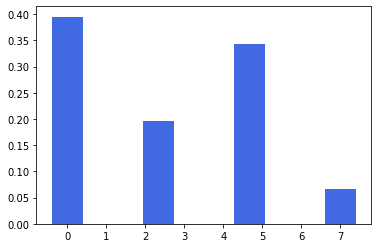

In [7]:
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  prob_g, color='royalblue', width= 0.8, label='simulation')

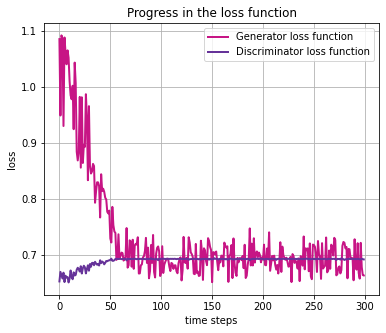

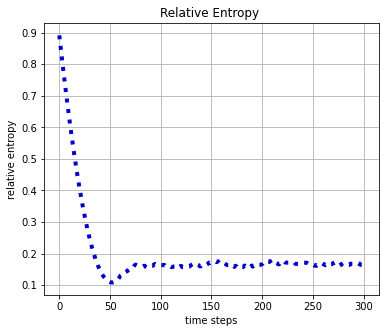

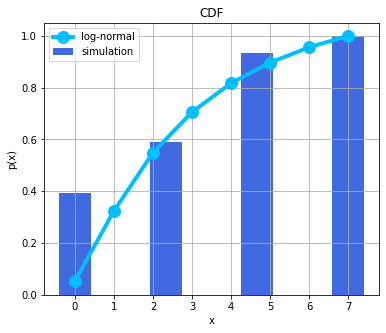

In [8]:
# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label = "Generator loss function", color = 'mediumvioletred', linewidth = 2)
plt.plot(t_steps, qgan.d_loss, label = "Discriminator loss function", color = 'rebeccapurple', linewidth = 2)
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()


# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title("Relative Entropy ")
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color ='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

#Plot the PDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1]+1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title("CDF")
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()